In [266]:
from commonfunctions import *
import skimage as sk 
import numpy as np
import matplotlib as mp
import scipy as sp
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Best angle: 0.0


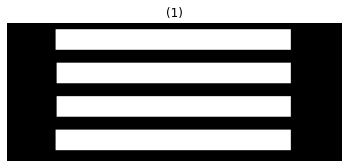

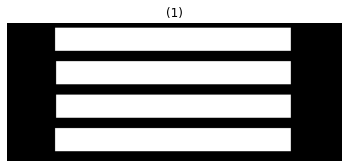

[11, 55, 76, 120, 141, 185, 206, 250]


interactive(children=(IntSlider(value=10, description='x', max=300), Output()), _dom_classes=('widget-interact…

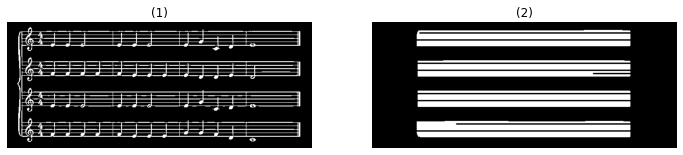

In [404]:
img = sk.io.imread('test2.png',as_gray=True)
img = img.astype(np.float64) / np.max(img) 
img = 255 * img 
img = img.astype(np.uint8)

    
    
    
def binarize(img,block_size = 35):
    t = sk.filters.threshold_local(img, block_size, offset=10)
    img_b = img < t
    return img_b


def deskew(img,delta=1,limit=60):
    def find_score(arr, angle):
        data = sp.ndimage.interpolation.rotate(arr, angle, reshape=False, order=0)
        hist = np.sum(data, axis=1)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        return hist, score
    delta = .5
    limit = 30
    angles = np.arange(-limit, limit+delta, delta)
    scores = []
    for angle in angles:
       hist, score = find_score(img, angle)
       scores.append(score)
    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]
    print('Best angle: '+str(best_angle))
    #correct skew
    img_n = sp.ndimage.interpolation.rotate(img, best_angle, reshape=False, order=0)
    return img_n




def line_detection(img):
    
    bounding_boxes = sk.measure.find_contours(img,0.8)
    newImg = np.zeros(img.shape)
    lines = []
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = [ np.min(box[:,1]),np.max(box[:,1]),np.min(box[:,0]),np.max(box[:,0]) ]
        Ymin -= 2
        Ymax += 2
        ar =  (Xmax-Xmin)/(Ymax-Ymin)
        if ( ( ar > 5)):
            rr, cc = sk.draw.rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=newImg.shape)
            rr = rr.astype(int)
            cc = cc.astype(int)
            newImg[rr, cc] = True 
            
            #lines.append(int(Ymin))
            #lines.append(int(Ymax))
            #print("sdsd")
    show_images([newImg])    
    bounding_boxes = sk.measure.find_contours(newImg,0.8)
    newImg = np.zeros(img.shape)
    lines = []
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = [ np.min(box[:,1]),np.max(box[:,1]),np.min(box[:,0]),np.max(box[:,0]) ]
        Ymin -= 2
        Ymax += 2
        ar =  (Xmax-Xmin)/(Ymax-Ymin)
        if ( ( ar > 5)):
            rr, cc = sk.draw.rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=newImg.shape)
            rr = rr.astype(int)
            cc = cc.astype(int)
            newImg[rr, cc] = True 

        lines.append(int(Ymin))
        lines.append(int(Ymax))
            #print("sdsd")
    show_images([newImg])
#     lines = np.sort(lines)
#     print(lines)
#     l = [lines[0]]
#     for i in range(1,len(lines)):
#         if lines[i]-lines[i-1] < 3:
#             continue
#         elif i == len(lines)-1:
#             l.append(lines[i])
#         else:
#             l.append(lines[i-1])
#             l.append(lines[i])
            
            
    return lines
 
def convertToLineSpace(row,lines):
    if row < lines[0]:
        return (-1,-1)
    if row == lines[0]:
        return (0,0)
    for i in range(1,len(lines)):
        if row == lines[i]:
            if i%2 == 0:
                return (5*(i)//2,5*(i)//2)
            else:
                return (5*((i)//2) + 4,5*((i)//2) + 4)
        if row < lines[i] and row > lines[i-1]:
            x = (lines[i]-lines[i-1])/3
            y = int((row-lines[i-1])/x)
            if i%2 == 1:                
                return ((5*((i-1)//2))+y,(5*((i-1)//2))+y+1)
            else:
                return (5*((i-2)//2) + 4,5*((i-2)//2) + 5)
    return (5*len(lines),5*len(lines))


img = binarize(img)
img = deskew(img,0.5)
img_thin = sk.morphology.skeletonize(img == True)


w  = 5
se = np.zeros((1,int(img.shape[1]*0.25)))
se1 = np.ones((3,2*w))
for i in range(se.shape[1]):
    se[0,i] = 1


#img_thin = img_thin > t
for i in range(1):
   img_thin = sk.morphology.dilation(img_thin,se1)
   img_thin = sk.morphology.dilation(img_thin,se1)

#img_thin = sk.morphology.skeletonize(img_thin == True)
img_thin = sk.morphology.closing(img_thin)


#img_lines,lines = line_detection(img_thin)
img_thin = sk.morphology.erosion(img_thin,se,shift_x=False, shift_y=False)
lines = line_detection(img_thin)
print((lines))
def f(x):
    #pass
    global lines
    print(convertToLineSpace(x,lines))
interact(f, x=widgets.IntSlider(min=0, max=300, step=1, value=10));

show_images([img,img_thin])
